In [1]:
import sys
sys.path.insert(0,'c:/MyDocs/integrated/') # adjust to your setup

%run "catalog_support.py" 
showHeader('Short Description of Open-FF')

Open-FF,"Short Description of Open-FF This file was generated on May 08, 2024 from data repository: openFF_data_2024_04_12.",Sponsored by FracTracker Alliance


In [2]:
# fetch data set
df = fh.get_df(os.path.join(hndl.sandbox_dir,'workdf.parquet'))


> ### An open-source project to transform the industry's FracFocus disclosure data into a usable resource.

## Data sources

The primary source of data for the Open-FF project is [FracFocus](https://fracfocus.org/), "The national hydraulic fracturing chemical disclosure registry."  These data cover most US states where fracking is active; many states require operators to use FracFocus to disclose chemical information.  FracFocus began in 2011 and continues to release diclosures regularly.

Open-FF uses the [bulk download](https://www.fracfocus.org/index.php?p=data-download) for the primary data set.  This set of over 6 million chemical records in over 200,000 disclosures is NOT a database. It contains several formats used by hundreds of different companies, often with poor attention to data completeness, quality, and standardization.  Summarizing patterns across the raw collection is very difficult.  Open-FF aims to transform this raw collection to produce data sets that improve standardization and completeness to facilitate big picture analysis of the industry's chemical use and disclosure practices.  

Further, Open-FF maintains supplementary data sets that are available to interested researchers. For example, the bulk download does not include chemical records released through May 2013, even though the data are [available as PDFs](http://fracfocusdata.org/DisclosureSearch/Search.aspx).  These supplementary resources provide access to the data in the PDFs. Additionally, connections to external lists, such as chemicals of concern, are provided in the data sets.


## Chemical Identification
> #### There is no more important piece of a chemical disclosure instrument than clear identification of the chemicals used.

Chemical usage in FracFocus is typically reported by both chemical names (such as "methanol") and a CAS registry number ("67-56-1").   However, many FracFocus disclosures do not provide unambiguous identity in both sources:

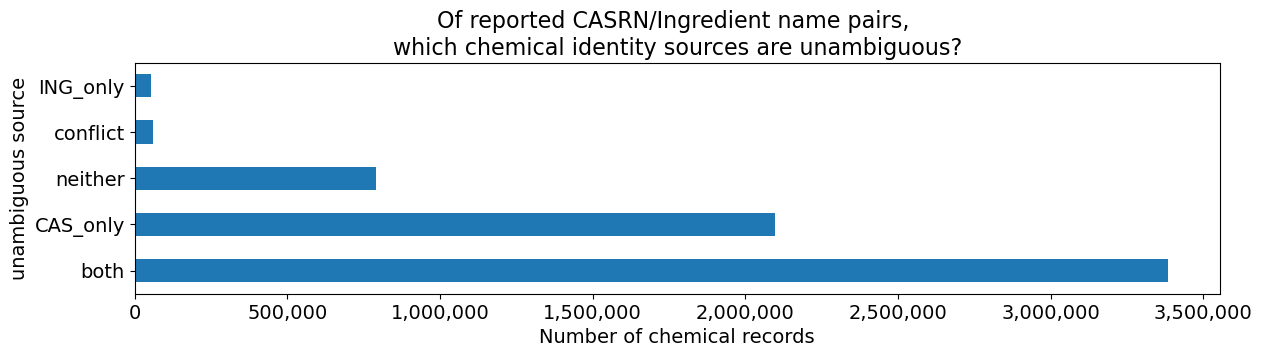

In [3]:
# t = pd.DataFrame({'number of records':[3548658,1640843,1554963,109406,89624]},index=['Both','Neither','CAS only','Conflicting','Ingredient name only'])
try:
    t = df.bgSource.value_counts()[:5]
except:
    t = df.source.value_counts()[:5]
ax = t.plot.barh(figsize=(14,3))
ax.set_title('Of reported CASRN/Ingredient name pairs, \nwhich chemical identity sources are unambiguous?',
            fontsize=16);
ax.set_ylabel('unambiguous source',fontsize=14)
plt.yticks(fontsize=14,rotation = 0);
ax.set_xlabel('Number of chemical records',fontsize=14)
plt.xticks(fontsize=14,rotation = 0);
ax = gca().xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'));


Open-FF evaluates both forms of chemical identity by comparing them to authoritative references (The Chemical Abstract Service's SciFinder database and EPA's CompTox resource) to generate the "best guess" identity for as many FracFocus records as possible. In addition, Open-FF clearly labels the records in which companies explicitly obscure chemical identity - the so-called Trade Secret claims. Finally, some records are associated with the "systems approach" format. 

In [4]:
# df = ana_set.Catalog_set(repo = repo_name, outdir='../common/').get_set(verbose=False)
proper = len(df[df.bgCAS.str[0].isin(['0','1','2','3','4','5','6','7','8','9'])])
propri = (df.bgCAS=='proprietary').sum()
sysmeta = (df.bgCAS=='non_chem_record').sum()
rest = len(df)-proper-propri-sysmeta
#print(f'{proper},{propri}, {len(df)-proper-propri}')

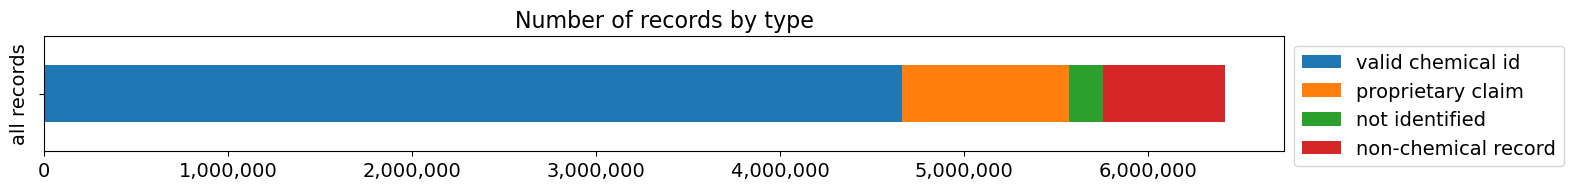

In [5]:
#from pylab import gca, mpl
#import matplotlib.pyplot as plt
t = pd.DataFrame({'valid chemical id':[proper],'proprietary claim':[propri],
                  'not identified': [rest],'non-chemical record':[sysmeta]},index=[''])
ax = t.plot.barh(stacked=True,
            figsize=(16,1.5),
           xlabel='all records');
ax.set_title('Number of records by type',fontsize=16)
ax.set_ylabel('all records',fontsize=14)
ax.set_xlabel('',fontsize=14)
plt.xticks(fontsize=14,rotation = 0);
ax = gca().xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, fontsize=14);
# plt.legend(loc='upper left');


## Uncovering Chemical Quantity
> #### After chemical identity, *how much* is used is of critical importance.

FracFocus does not explicitly provide reports of chemical quantities in their pdf files. Text on the FracFocus website dwells on the **proportion** of added chemicals in a typical fracking job. That proportion can be pretty small - usually less than 2% - as this figure from the FracFocus website illustrates.

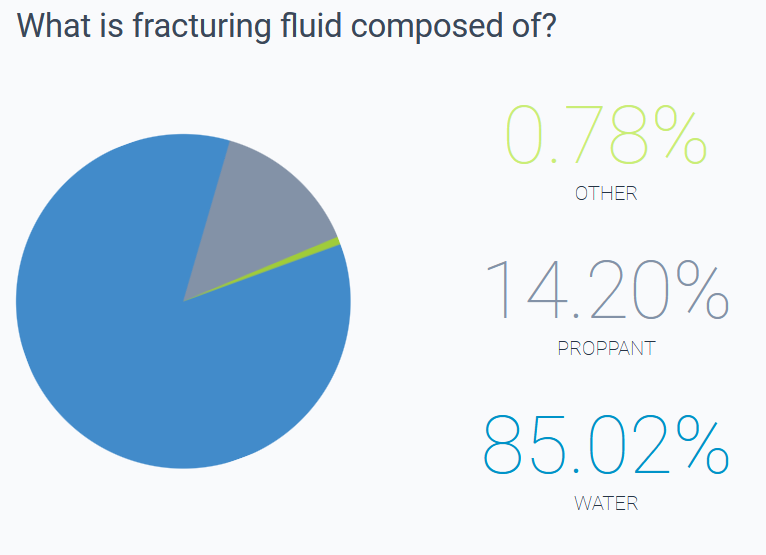

In [6]:
from IPython.display import Image
# print(hndl.nb_images_dir)
Image(filename=os.path.join(hndl.nb_images_dir,'FF_component_pie.png'), width=400)


However, the actual **quantity** of the added chemicals can be quite large simply because the whole job is enormous. For example, the chemical Ethylene glycol (CASRN: 107-21-1) is a material on several lists of chemicals of concern and is used in about 40% of fracking jobs. 

As part of our effort to explicitly document quantity, we can *calculate* the mass of all the chemicals if some basic information is present in a disclosure.

The two basic disclosure values - volume of water used as the carrier and the percent of the total mass that the carrier occupies - allow Open-FF to calculate the total mass of the fracking job.  From there, the mass of individual records can be calculated using the reported percent of total mass for each chemical.  

This method has been used by other researchers and the FracFocus team has acknowledged that it is valid.  One important caveat: the percent masses reported in FracFocus are the maximum of a range that a manufacturer reports in MSDS documents.  Therefore, the masses Open-FF calculates are maximums. 

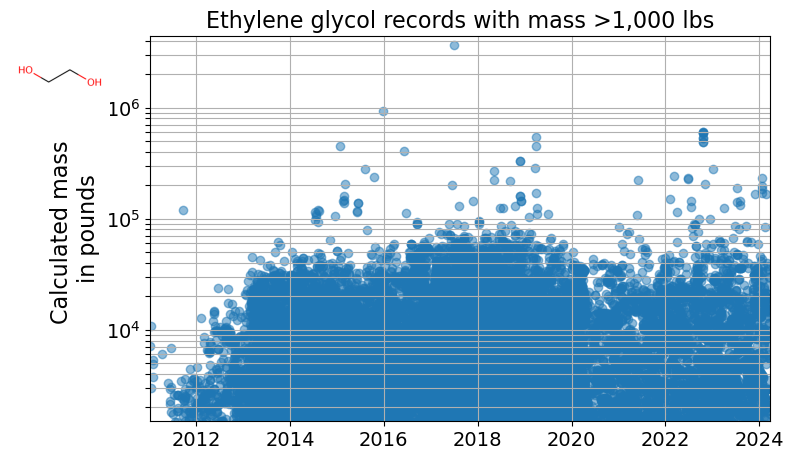

In [7]:
import matplotlib.image as image
im = image.imread(os.path.join(hndl.nb_images_dir,'107-21-1.png'))
fig, ax = plt.subplots(figsize=(8,5))

t = df[(df.bgCAS=='107-21-1')&(df.calcMass>1000)].copy()
ax.scatter(t.date,t.calcMass, alpha=.5) 
#plt.set_figsize(10,4)

plt.ylabel('Calculated mass \nin pounds',fontsize=16);
plt.title(f'Ethylene glycol records with mass >1,000 lbs',fontsize=16);
ax.set(yscale='log')
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14)
newax = fig.add_axes([-0.05,0.7,0.2,0.2], anchor='NW', zorder=2)
newax.imshow(im)
newax.axis('off')
locmaj = matplotlib.ticker.LogLocator(base=10,subs='all') 
ax.yaxis.set_major_locator(locmaj)
# plt.set(figsize=(10,6))
ax.set(ylim=(1500,t.calcMass.max()*1.2))
ax.set(xlim=(t.date.min(),t.date.max()));
ax.grid()


In the graph above, each dot represents the calculated mass of Ethylene glycol from a single fracking job above 1,000 pounds.

In addition to these calculations, recent versions of Open-FF use a column in FracFocus named "MassIngredient" that is available for about half of FracFocus records; Open-FF uses this data to validate calculations described above and, in some cases, it is the only record of mass available.

## Correcting and consolidating labels
Open-FF also aims to make searching and aggregating data more feasible by cleaning up other data fields.  For example, the supplier and oilfield service company, Halliburton, is represented by more than 80 versions of the company name. Here's a sample of those versions in the Supplier field:
>'Halliburton', 'HALLIBURTON', 'HES', 'Halliburton Energy Services, Inc. (HES)', 'Halliburton Energy Services, Inc', 'Hallibrton', 'Hallliburton', 'Halliburton Energy Services', 'Halliburton Energy Services, Inc.', 'HES Multi-Chem', 'Hallibruton Energy Services', 'Hallibuton',      'Halluburton', 'Halliburton, Multi-Chem', 'Halliurton', 'Halliberton', and 'HES Chemicals.' 

This lack of standardization makes thorough searches across 6 million records impossible.

Open-FF employs curated translation tables to create new fields from these unstandardized fields.  For instance, all of the verisons above in Supplier are assigned to the value 'halliburton' in the bgSupplier field.  This allows us to produce comprehensive views of the whole data set.  In the following graph, the number of records for the biggest users of Naphthalene is shown - this time for operating companies, another curated field.


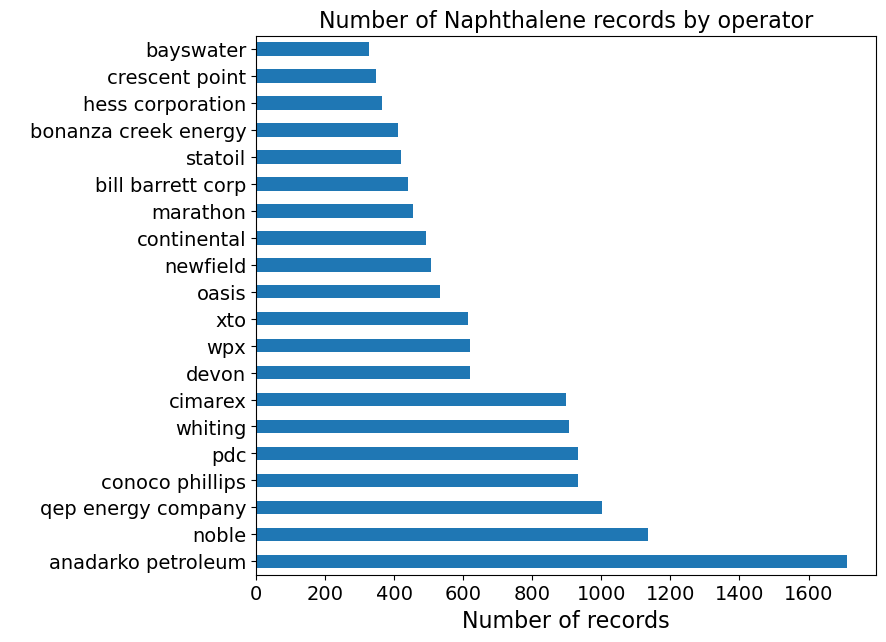

In [8]:
ngroups = 20
ax = df[df.bgCAS=='91-20-3'].groupby('bgOperatorName')['DisclosureId'].count()\
     .sort_values(ascending=False)[:ngroups].plot.barh(figsize=(8,7))
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14)
plt.xlabel('Number of records',fontsize=16);
plt.ylabel(' ')
plt.title(f'Number of Naphthalene records by operator',fontsize=16);

In [9]:
# from IPython.display import Image
# Image(filename='./docs/naphthalene2.png', width=500)

## Filtering
Because FracFocus has a range of data quality and Open-FF assigns flags to questionable records and disclosures, users of Open-FF products can choose to filter out lower quality data or other problem data before performing analysis. Additionally, these flags can assist researchers interested in patterns of disclosure completeness and lack of transparency.

## Products

Open-FF is an open-source project.  Through early 2023, project code was published at [CodeOcean](https://codeocean.com/capsule/9423121/tree) which allows any user to re-run the code, with or without modification. CodeOcean also certifies that the code is reproducible.  More recently, the project is published at GitHub ([openFF](https://github.com/gwallison/openFF)) and includes documentation.
- Users can explore the data set using the [Data Browser](https://storage.googleapis.com/open-ff-browser/Open-FF_Catalog.html). This include tables that are interactive, allowing for easy sorting and searching.  For example:
    - The chemical index provides a quick method to scan and search through the list of over 1300 chemicals used in FracFocus. This index lets users subset the material based of lists of chemicals of concern and other factors.  For each item on this table, the user can view summary analysis of the chemical.  In addition, from this table, a user can download a slice of the data set of just the records for this chemical.
    - The synonym index helps users identify a CAS number if they know a particular chemical name. The results in this table also point to summary analysis of each chemical.
    - The operator index sumarizes where and when a company is active, their water use through time as well as summaries of chemicals of concern and trade secret designations.
- Open-FF is currently publishing a [periodic summary](https://frackingchemicaldisclosure.wordpress.com/2021/02/13/data-new-disclosures/) of all the disclosures published since the last report.

If you are interested in these data, but these products don't quite serve your needs, please contact us.  The goal of this project is to make the research of fracking chemicals more accessible and we are interested in adding features to assist analysis.